In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy
import astropy.table as atpy
from astropy import cosmology
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Column

import sherpa
import sherpa.ui as ui

import scipy
import scipy.integrate
import scipy.optimize as op

import logging

import time

import emcee
import corner


#add in all needed modules for things here...

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


In [2]:
#avoid sherpa suppression of traceback
import sys
sys.tracebacklimit = 100

In [3]:
#default parameters and unit conversion factors
import defaultparams.params as params
import defaultparams.uconv as uconv

#functions to read data into format used by module
from massmod.set_prof_data import set_ne, set_tspec, set_meta

#function to fit the gas density profile
from massmod.fit_density import fitne, find_nemodeltype

#function to determine mass profile through backwards modelling
from massmod.fit_temperature import fit_ml, fit_mcmc

#analyze the marginalized posterior distribution
from massmod.posterior_mcmc import calc_posterior_mcmc, samples_results

#plotting functions
from massmod.plotting import plt_mcmc_freeparam, plt_summary, plt_summary_nice

#functions specifically to generate mock data from Vikhlinin+ profiles
from exampledata.vikh_prof import vikh_tprof, vikh_neprof, gen_vik_data

# Goal:
The primary goal of this example script is to showcase the tools available in the massmod package using mock data. The mock data is produced by randomly sampling the density and temperature profiles models published in Vikhlinin+06 for a sample of clusters. A secondary goal of this example is thus to also explore how the backwards mass modeling process used in the massmod package compares to the forward fitting results of Vikhlinin+06. The mock profiles allow for a flexible choice in noise and radial sampling rate, which allows for exploration of how these quantities affect the output of the backwards-fitting process. There is also some flexibility built into the massmod package that can be additionally tested here such as allowing for the stellar mass of the central galaxy to be included (or not included) in the model of total gravitating mass. If the stellar mass profile of the BCG is toggled on, the values for the BCG effective radius Re are pulled from the 2MASS catalog values for a de Vaucouleurs fit to their K-band data.
    
After generating the mock temperature and density profiles, the below code walks the user through fitting a model to the gas density profile, and performing the backwards-fitting mass modelling analysis. The output includes a non-parametric model fit to the temperature profile, the total mass profile and its associated parameters describing the profile, and the contributions of different mass components (i.e., DM, stars, gas) to the total mass profile.

  # A note on usage:
Any of the clusters in Vikhlinin+06 are options to be used to generate randomly sampled temperature and density profiles. The full list of clusters is as follows:
    
vikhlinin clusters:  
 A133  
 A262  
 A383  
 A478  
 A907  
 A1413  
 A1795  
 A1991  
 A2029  
 A2390  
 RXJ1159+5531  
 MKW4  
 USGCS152   
 
After selecting one of these clusters, this example script will automatically generate the cluster and profile data in the proper format to be used by the module. If you have your own data you would like to analyze with the massmod package, please see the included template.py file for instructions.
    

In [4]:
#select any cluster ID from the Vikhlinin+ paper
clusterID='A262'

# 1. Generate mock gas density and temperature profiles 
- according to the modeles in Vikhlinin+06. Some pertinent details are included below, more details are included in the docstrings of the functions.

Args for gen_vik_data():  
N_ne: the number of gas density profile data points  
N_temp: the number of temperature profile  
noise_ne: the percent noise on the density values  
noise_temp: the percent noise on the temperature values 
refindex: index into profile where Tmodel = Tspec
incl_mstar: include stellar mass of the central galaxy in the model for total gravitating mass  
incl_mgas: include gas mass of ICM in the model for total gravitating mass  

In [5]:
clustermeta, ne_data, tspec_data, nemodel_vikh, tmodel_vikh \
    = gen_vik_data(clusterID=clusterID, 
                   N_ne=15,  
                   N_temp=5,  
                   noise_ne=0.01, 
                   noise_temp=0.05, 
                   refindex=-1,
                   incl_mstar=1, 
                   incl_mgas=1) 


Now let's take a look at the returns... while these are generated automatically here, if you use your own data, things should be in a similar form.

In [6]:
# clustermeta: 
# dictionary that stores relevant properties of cluster 
#     (i.e., name, redshift, bcg_re: the effective radius of the central galaxy in kpc, 
#      bcg_sersc_n: the sersic index of the central galaxy)
# as well as selections for analysis 
#     (i.e., incl_mstar, incl_mgas, refindex as input previously)

clustermeta

{'bcg_re': 10.09,
 'bcg_sersic_n': 4.0,
 'incl_mgas': 1,
 'incl_mstar': 1,
 'name': 'A262',
 'refindex': -1,
 'z': 0.0162}

In [7]:
#ne_data: dictionary that stores the mock "observed" gas density profile  

ne_data[:3]

radius,ne,ne_err,radius_lowerbound,radius_upperbound
float64,float64,float64,float64,float64
10.0,0.012995819646277034,0.0001310260293597479,0.0,0.0
13.675241327079377,0.010038302596209667,0.00010007725921203061,0.0,0.0
18.701222535385973,0.007610318984878476,7.634202390585732e-05,0.0,0.0


In [8]:
#tspec_data: dictionary that store the mock "observed" temperature profile  
tspec_data[:3]

radius,tspec,tspec_err,tspec_lowerbound,tspec_upperbound,radius_lowerbound,radius_upperbound
float64,float64,float64,float64,float64,float64,float64
10.0,1.3745690738306993,0.0734738494052246,0.0734738494052246,0.0734738494052246,0.0,0.0
29.906975624424415,2.3264144732173664,0.11168366861895834,0.11168366861895834,0.11168366861895834,0.0,0.0
89.4427190999916,2.3568161750185466,0.11770229491648437,0.11770229491648437,0.11770229491648437,0.0,0.0


Let's take a look at how our sampled profiled compare to the model we're sampling from ...

Text(0,0.5,u'kT [keV]')

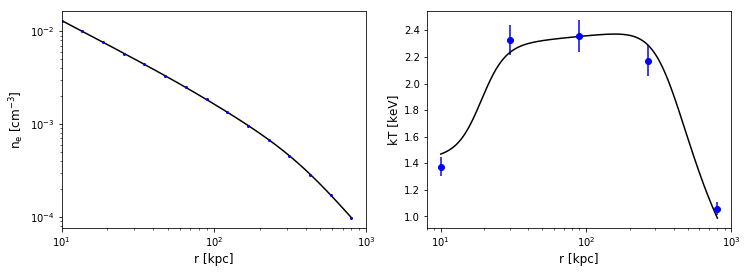

In [22]:
fig1 = plt.figure(1, (12, 4))
ax = fig1.add_subplot(1, 2, 1)


'''
mock gas denisty profile
'''
#plot vikhlinin+06 density model
xplot=np.logspace(np.log10(min(ne_data['radius'])),np.log10(max(ne_data['radius'])),1000)
plt.loglog(xplot,vikh_neprof(nemodel_vikh,xplot),'k')
plt.xlim(xmin=min(ne_data['radius']))

#plot sampled density data
plt.errorbar(ne_data['radius'], ne_data['ne'],
             xerr=[ne_data['radius_lowerbound'], ne_data['radius_upperbound']],
             yerr=ne_data['ne_err'], marker='o',markersize=2,linestyle='none', color='b')

ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.xlabel('r [kpc]')
plt.ylabel('$n_{e}$ [cm$^{-3}$]')


'''
mock temperature profile
'''
ax = fig1.add_subplot(1, 2, 2)

#plot vikhlinin+06 temperature model
xplot=np.logspace(np.log10(min(tspec_data['radius'])),np.log10(max(tspec_data['radius'])),1000)
plt.semilogx(xplot,vikh_tprof(tmodel_vikh,xplot),'k-')

#plot sampled temperature data
plt.errorbar(tspec_data['radius'], tspec_data['tspec'],
             xerr=[tspec_data['radius_lowerbound'], tspec_data['radius_upperbound']],
             yerr=[tspec_data['tspec_lowerbound'], tspec_data['tspec_upperbound']],
             marker='o', linestyle='none',color='b')

plt.xlabel('r [kpc]')
plt.ylabel('kT [keV]')



# 2. Fit the gas density profile with a parametric model

Determine the best fitting model to the density profile through Levenberg-Marquardt $\chi^2$ minimization.   

Output will be one of the following,  

'single_beta':  
$n_{e} = n_{e,0} \ (1+(r/r_{c})^{2})^{-\frac{3}{2}\beta}$

'cusped_beta':  
$n_{e} = n_{e,0} \ (r/r_{c})^{-\alpha} \ (1+(r/r_{c})^{2})^{-\frac{3}{2}\beta+\frac{1}{2}\alpha}$

'double_beta':  
$n_{e} = n_{e,1}(n_{e,0,1}, r_{c,1}, \beta_1)+n_{e,2}(n_{e,0,2}, r_{c,2}, \beta_2)$

'double_beta_tied':  
$n_{e} = n_{e,1}(n_{e,0,1}, r_{c,1}, \beta)+n_{e,2}(n_{e,0,2}, r_{c,2}, \beta)$

In [23]:
#suppress verbose log info from sherpa
logger = logging.getLogger("sherpa")
logger.setLevel(logging.ERROR)

#add option to plot... with optplt
nemodeltype=find_nemodeltype(ne_data=ne_data, tspec_data=tspec_data, optplt=1)
print nemodeltype

cusped_beta


In [11]:
#Find the parameters and param errors of the best-fitting gas density model

#turn on logging for sherpa to see details of fit
logger = logging.getLogger("sherpa")
logger.setLevel(logging.INFO)

nemodel=fitne(ne_data=ne_data,tspec_data=tspec_data,nemodeltype=str(nemodeltype)) #[cm^-3]

Dataset               = 1
Method                = levmar
Statistic             = chi2
Initial fit statistic = 129105
Final fit statistic   = 13.0383 at function evaluation 243
Data points           = 15
Degrees of freedom    = 11
Probability [Q-value] = 0.290832
Reduced statistic     = 1.1853
Change in statistic   = 129092
   cuspedbeta1d.ne0   0.000587057 
   cuspedbeta1d.rc   340.186     
   cuspedbeta1d.beta   0.660409    
   cuspedbeta1d.alpha   0.882429    
cuspedbeta1d.rc lower bound:	-18.5255
cuspedbeta1d.alpha lower bound:	-0.00496912
cuspedbeta1d.rc upper bound:	19.8625
cuspedbeta1d.alpha upper bound:	0.00488684
cuspedbeta1d.beta lower bound:	-0.0167609
cuspedbeta1d.ne0 lower bound:	-3.46191e-05
cuspedbeta1d.beta upper bound:	0.0184797
cuspedbeta1d.ne0 upper bound:	3.62808e-05
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 1-sigma (68.2689%) bounds:
   Param

In [12]:
#nemodel stores all the useful information from the fit to the gas denisty profile
print nemodel.keys()

['parmins', 'nefit', 'dof', 'parmaxes', 'rchisq', 'chisq', 'parvals', 'parnames', 'type']


# 3. Maximum likelihood estimation of free params in mass profile model

Perform the backwards-fit of the mass model. The free parameters in the fit are:
- the mass concentration "c" of the NFW profile used to model the DM halo, 
- the scale radius "Rs" of the NFW profile
- optionally, the normalization of the Sersic model $\rho_{\star,0}$ used to model the stellar mass profile of the central galaxy

In [13]:
ml_results=fit_ml(ne_data,tspec_data,nemodel,clustermeta)

scipy.optimize results
ML: c= 4.5094080450157685
ML: rs= 138.41227459206647
ML: normsersic= 8.827434381725256


these maximum likelihood results are later going to be used to initialize the walkers in our Markov chain...

In [14]:
print ml_results

[4.5094080450157685, 138.41227459206647, 8.827434381725256]


# 4. Use the MCMC algorithm to determine the best fitting values and errors of the mass profile model 

The backwards-fitting mass modelling process is performed using the MCMC algorithm emcee. The walkers of the ensemble are started from the parameter estimation output by the maximum likelihood analysis. Note the number of cores the MCMC analysis is run on is an option here. 

**warning: default Nwalkers, Nsteps, Nburnin are small numbers to allow for fast testing

Returns:  
samples - the marginalized posterior distribution  
sampler - the sampler class output by emcee  

In [15]:
#fit for the mass model and temperature profile model through MCMC
samples, sampler = fit_mcmc(ne_data=ne_data, 
                            tspec_data=tspec_data, 
                            nemodel=nemodel, 
                            ml_results=ml_results, 
                            clustermeta=clustermeta,
                            Ncores=params.Ncores,
                            Nwalkers=params.Nwalkers,
                            Nsteps=params.Nsteps,
                            Nburnin=params.Nburnin)

0.00010447715151280065
9.188680701482658e-05
8.602474682665836e-05
acceptance rate of walkers:
[0.8        0.83333333 0.73333333 0.8        0.83333333 0.86666667
 0.76666667 0.8        0.83333333 0.73333333 0.8        0.86666667
 0.83333333 0.9        0.86666667 0.86666667 0.76666667 0.83333333
 0.8        0.8        0.76666667 0.7        0.56666667 0.73333333
 0.73333333 0.9        0.63333333 0.63333333 0.83333333 0.83333333]

autocorrelation time: autocorrelation time cannot be calculated



In [16]:
#analyze the marginalized MCMC distribution to calculate Rdelta, Mdelta
samples_aux = calc_posterior_mcmc(samples=samples, 
                                  nemodel=nemodel, 
                                  clustermeta=clustermeta)

In [17]:
#summary of the MCMC results
mcmc_results=samples_results(samples=samples,
                             samples_aux=samples_aux,
                             clustermeta=clustermeta)

MCMC results
MCMC: c= (4.509219706733296, 0.04388118726401746, 0.046458964612157594)
MCMC: rs= (138.4116076171151, 0.09330102505393256, 0.12021051250926007)
MCMC: normsersic= (8.826513390695355, 0.12492305698119743, 0.11322448431091381)


# 5. Plot the resuts

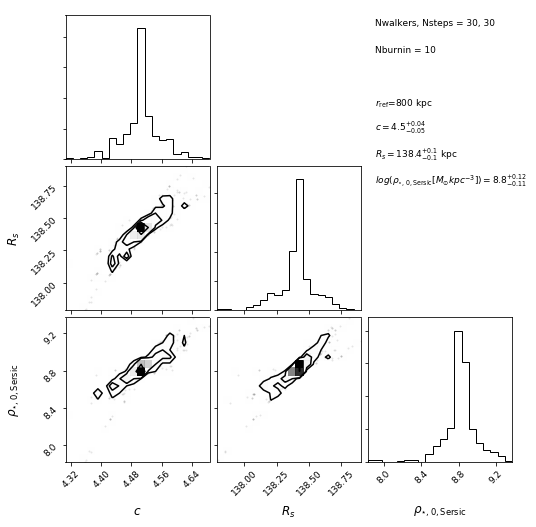

In [18]:
#Corner plot of marginalized posterior distribution of free params from MCMC
fig1 = plt_mcmc_freeparam(mcmc_results, samples, sampler, tspec_data, clustermeta)

massmod/density_models.py:72: RuntimeWarning: divide by zero encountered in power
  * ((1.+((x/rc)**2.))**((-3.*beta/2.)+(alpha/2.)))  # [cm^-3]
/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


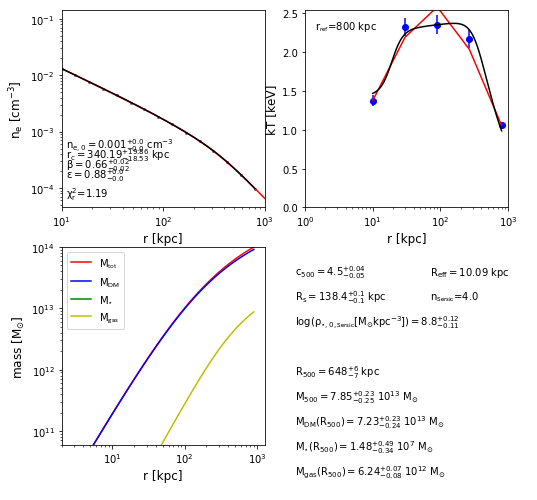

In [19]:
#Summary plot: density profile, temperature profile, mass profile
fig2 = plt_summary(ne_data, tspec_data, nemodel, mcmc_results, clustermeta)

ax=fig2.add_subplot(2,2,1)
xplot=np.logspace(np.log10(min(ne_data['radius'])),np.log10(800.),1000)
plt.loglog(xplot,vikh_neprof(nemodel_vikh,xplot),'k')
plt.xlim(xmin=min(ne_data['radius']))

ax=fig2.add_subplot(2,2,2)
xplot=np.logspace(np.log10(min(tspec_data['radius'])),np.log10(800.),1000)
plt.semilogx(xplot,vikh_tprof(tmodel_vikh,xplot),'k-')